In [124]:
import qutip as qp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
def gaussian(x,x0,sigma):
    return (1/np.sqrt(2*np.pi*sigma*sigma))*np.exp(-(x-x0)**2/2/sigma/sigma)

In [412]:
print (qp.about())


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.0.4
Numpy Version:      1.26.4
Scipy Version:      1.14.1
Cython Version:     3.0.11
Matplotlib Version: 3.9.2
Python Version:     3.10.12
Number of CPUs:     12
BLAS Info:          Generic
INTEL MKL Ext:      False
Platform Info:      Windows (AMD64)
Installation path:  C:\ProgramData\miniconda3\lib\site-packages\qutip
Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated 

# Two level system modelling
The Hamiltonian is 
$\mathcal{H} = -\hbar \Delta/2 \sigma_z  + \hbar \Omega/2 \sigma_x $

Total time: 0.954 s, Elapsed per loop:0.019 s


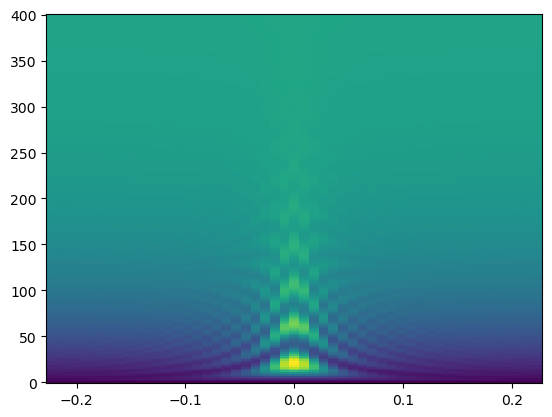

In [409]:
t2star = 19
width = np.sqrt(2)/t2star

detuning_array = 2*np.pi* np.linspace(-3*width, 3*width, 51)
detuning_step = np.diff(detuning_array)[0]
stateout = []

start = time.time()
for j, detuning in enumerate(detuning_array):
    print ('Detuning:%.3f'%detuning, end='\r')
    Omega = 2*np.pi*0.0234
    Hamiltonian = -detuning/2 * qp.sigmaz() + Omega/2 * qp.sigmax()
    psi0 = qp.fock(2, 0)*qp.fock(2,0).dag()
    gamma01 = 1/91
    dephase = gamma01*1
    decay01 = np.sqrt(gamma01/2)*qp.sigmax() #  drive is non zero.
    # decay01 = np.sqrt(gamma01)*qp.sigmam() # drive is zero.
    dephasing = np.sqrt(dephase/2)*qp.sigmaz()
    pop0 = qp.fock(2, 0)*qp.fock(2,0).dag()
    pop1 = qp.fock(2, 1)*qp.fock(2,1).dag()
    time_array = np.linspace(0, 400, 201)
    res = qp.mesolve(Hamiltonian,
                 psi0,
                 time_array,
                 # e_ops=[sigmax, sigmay, sigmaz],
                 e_ops=[pop0, pop1], # pop0, pop1, pop2],
                 c_ops=[decay01, dephasing],
                 # options = qp.Options(nsteps=20001)
                )
    stateout.append([res.expect[0], res.expect[1]])
duration = (time.time()-start)
print ('Total time: %.3f s, Elapsed per loop:%.3f s'%(duration, (duration)/len(detuning_array)))
    # stateout.append(res.expect[0])
stateout = np.array(stateout)
plt.pcolormesh(detuning_array/2/np.pi, time_array, stateout[:,1].T)
# plt.axvline(x=np.pi/(Omega), color='black',ls='-.')
# plt.plot(time_array, res.expect[0])
# plt.plot(time_array, res.expect[1])
# plt.plot(time_array, 0.5+0.5*np.exp(-time_array*gamma01),'--')
# plt.plot(time_array, 0.5 - 0.5*np.exp(-time_array*gamma01),'--')

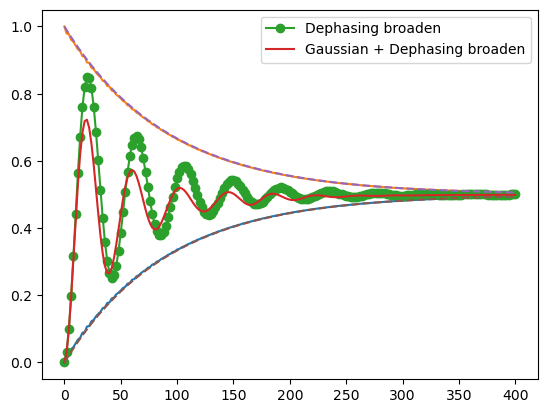

In [410]:
plt.plot(time_array, stateout[:,1][0],'-')
plt.plot(time_array, stateout[:,0][0],'-')

idx = np.searchsorted(detuning_array, 0)
plt.plot(time_array, stateout[:,1][idx],'o-', label='Dephasing broaden')
# plt.plot(time_array, stateout[:,0][idx],'o-')
# print(detuning_step)
average_up = np.sum([gaussian(detuning_array[j],0,width)*stateout[:,1][j]*detuning_step for j in range(len(detuning_array))],axis=0)
plt.plot(time_array,average_up, label='Gaussian + Dephasing broaden')
plt.plot(time_array, 0.5+0.5*np.exp(-time_array*gamma01),'--')
plt.plot(time_array, 0.5-0.5*np.exp(-time_array*gamma01),'--')
plt.legend()

# Three level system with tunable detunings, drive amplitudes, and spontaneous emission rate. 
For context, I am following the lecture notes on Raman transitions here. (https://people.ee.duke.edu/%7Ejungsang/ECE590_01/ThreeLevelSystems.pdf)
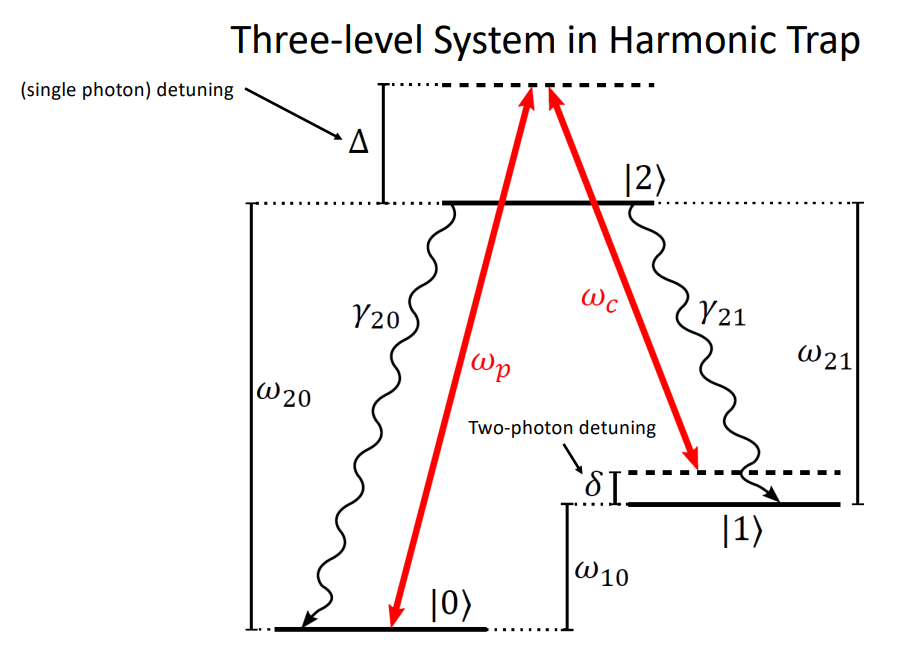

## Upon rotating wave approximation to remove the higher order terms, we are left with this
$\mathcal{H} = \hbar \Delta \ket{0}\bra{0} + \hbar  (\Delta + \delta) \ket{1}\bra{1} + \Omega_{02}/2\left(\ket{0}\bra{2} + \ket{2}\bra{0}\right)+
\Omega_{12}e^{i\delta\phi}/2\left(\ket{1}\bra{2} + \ket{2}\bra{1}\right)$

## Two photon detuning sweep

In [2]:
# parameters
out = []
detuning_scan = np.linspace(-0.2, 0.2, 11)
for j, _detuning in enumerate(detuning_scan):
    print (j, end='\r')
    sp_detuning = -2*np.pi*1000 # single photon detuning in ns^-1
    tp_detuning = 2*np.pi*_detuning # two photon detuning in ps^{-1}
    gamma01 = 1/(50e3) # spin lifetime in ps^-1
    gamma02 = 1/(250) # diagonal spontaneous emission rate in ps^-1
    gamma12 = 1/0.50 # vertical spontaneous emission rate in ps^-1
    
    omega = 2*np.pi*10 # driving amplitude ~ 10 GHz
    # w10 = 2*np.pi*0.020 # ground state splitting in ps^{-1} 
    phi = np.pi/4  # angle between drives
    
    # initial state
    psi0 = qp.fock(3, 0)  # ground state
    
    # population operators
    pop0 = qp.Qobj([[1, 0, 0], [0, 0, 0], [0, 0, 0]])
    pop1 = qp.Qobj([[0, 0, 0], [0, 1, 0], [0, 0, 0]])
    pop2 = qp.Qobj([[0, 0, 0], [0, 0, 0], [0, 0, 1]])
    a02 = qp.Qobj([[0, 0, 1], [0, 0, 0], [0, 0, 0]])
    a12 = qp.Qobj([[0, 0, 0], [0, 0, 1], [0, 0, 0]])
    a01 = qp.Qobj([[0, 1, 0], [0, 0, 0], [0, 0, 0]])
    
    # collapse operators
    decay02 = np.sqrt(gamma02) * qp.Qobj([[0, 0, 1], [0, 0, 0], [0, 0, 0]])
    decay12 = np.sqrt(gamma12) * qp.Qobj([[0, 0, 0], [0, 0, 1], [0, 0, 0]])
    decay01 = np.sqrt(gamma01) * qp.Qobj([[0, 1, 0], [0, 0, 0], [0, 0, 0]])
    
    # eops
    sigmax = a01 + a01.dag()
    sigmay = -1j * a01 + 1j * a01.dag()
    sigmaz = pop0 - pop1
    # # hamiltonian
    hamilton = sp_detuning*pop0 +\
                (tp_detuning+sp_detuning)*pop1 +\
                0.5*omega*qp.Qobj([[0, 0, 1], [0, 0, 0], [1, 0, 0]]) + \
                0.5*(omega)*np.exp(1j*phi)*qp.Qobj([[0, 0, 0], [0, 0, 1], [0, 0, 0]]) +\
                0.5*(omega)*np.exp(-1j*phi)*qp.Qobj([[0, 0, 0], [0, 0, 0], [0, 1, 0]])
    # solve
    res = qp.mesolve(hamilton,
                     psi0,
                     np.linspace(0, 30, 401),
                     # e_ops=[sigmax, sigmay, sigmaz],
                     e_ops=[pop1], # pop0, pop1, pop2],
                     c_ops=[decay02, decay12, decay01],
                     # options = qp.Options(nsteps=20001)
                    )
    out.append(res.expect[0])

0.9996093176178619

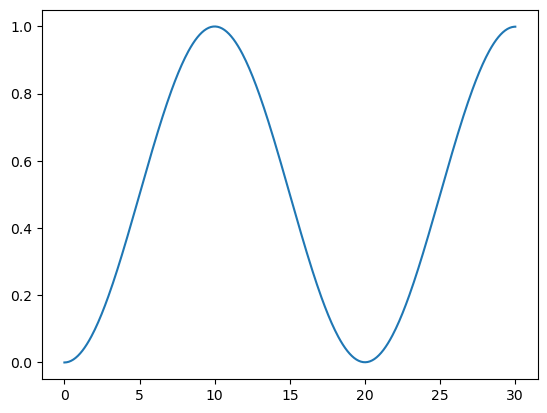

In [3]:
plt.plot(res.times, out[np.searchsorted(detuning_scan,0)])
max(out[np.searchsorted(detuning_scan,0)])

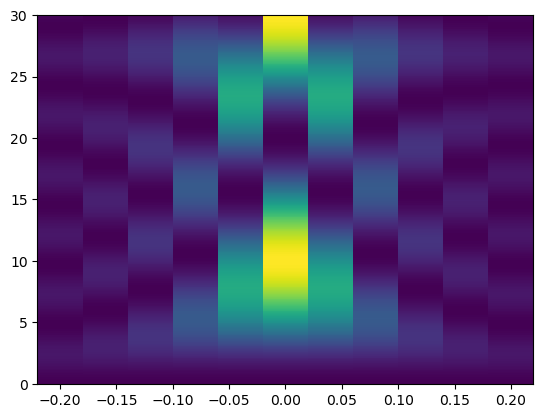

In [4]:
plt.pcolormesh(detuning_scan, res.times,np.array(out).T) 

In [435]:
# parameters
rabi_tp = 2*np.pi*0.0234 # MHz
rabi_ratio = 0.0077
gamma01 = 1/90 # 0.011
gamma02 = 1/0.5
gamma12 = 1/200 # gamma02/branching_ratio
sp_detuning = -2*np.pi*600 # single photon detuning in ns^-1
omega1 = np.sqrt(abs(rabi_tp*2*sp_detuning/rabi_ratio))
omega2 = omega1*rabi_ratio
shift = (1/4/sp_detuning)*(omega1**2 - omega2**2)
print ('Omega2ph:{:.3f}, Omega1:{:.3f}, Omega2:{:.3f}, Shift:{:.3f} GHz'.format(rabi_tp/2/np.pi, omega1/2/np.pi, omega2/2/np.pi, shift/2/np.pi))
# omega = 2*np.pi*10 # driving amplitude ~ 10 GHz

phi = 0
# initial state

# population operators
pop0 = qp.fock(3, 0)*qp.fock(3,0).dag() # ground state 1
pop1 = qp.fock(3, 1)*qp.fock(3,1).dag() # ground state 2
pop2 = qp.fock(3, 2)*qp.fock(3,2).dag() # excited state 1
a02 = qp.fock(3, 0)*qp.fock(3,2).dag() # ground 1 -> excited state 1
a12 = qp.fock(3, 1)*qp.fock(3,2).dag() # ground 2 -> excited state 2
a01 = qp.fock(3, 0)*qp.fock(3,1).dag() # ground 1 -> ground 2

# collapse operators
decay02 = np.sqrt(gamma02) * (a02) # ground excited 1
decay12 = np.sqrt(gamma12) * (a12) # ground excited 2
decay01 = np.sqrt(gamma01/2) * (a01+a01.dag()) # ground 1 ground 2.

# eops
sigmax = a01 + a01.dag()
sigmay = -1j * a01 + 1j * a01.dag()
sigmaz = pop0 - pop1
# # hamiltonian
    
psi0 = pop0 # qp.fock(3, 0)  # ground state
pi_pulse = 1/2/(rabi_tp/2/np.pi)
time_array = np.linspace(0, 200, 3000)
out = []
out1 = []
out2 = []

detuning_scan = np.linspace(-0.45, 0.45, 501)*2*np.pi + shift # np.random.normal(0, np.sqrt(2)/t2star, 100) + shift/2/np.pi

# omega1 = 0 
# omega2 = 0
# np.linspace(-0.15, 0.15, 31) + shift/2/np.pi
for j, _detuning in enumerate(detuning_scan):
    print (j, end='\r')
    tp_detuning = _detuning # 2*np.pi*_detuning 
    hamilton = sp_detuning*pop0 +\
                (tp_detuning+sp_detuning)*pop1 +\
                0.5*omega1*qp.Qobj([[0, 0, 1], [0, 0, 0], [1, 0, 0]]) + \
                0.5*(omega2)*np.exp(1j*phi)*qp.Qobj([[0, 0, 0], [0, 0, 1], [0, 0, 0]]) +\
                0.5*(omega2)*np.exp(-1j*phi)*qp.Qobj([[0, 0, 0], [0, 0, 0], [0, 1, 0]])

    res = qp.mesolve(hamilton,
                     psi0,
                     time_array,
                     e_ops=[pop1, pop0, pop2],# pop0, pop1, pop2],
                     c_ops=[decay02, decay12, decay01],
                     # options = qp.Options(nsteps=20001)
                    )
    out.append(res.expect[0])
    out1.append(res.expect[1])
    out2.append(res.expect[2])
out = np.array(out)
out1 = np.array(out1)
out2 = np.array(out2)
filename = r'C:\Users\phys1476\Desktop\Simulation\20250405_RabiScan_Finale_GroundSigmaX.npz'
np.savez(filename, tp_detuning = detuning_scan, sp_detuning = sp_detuning, pop1 = out, pop0 = out1, pop2 = out2, time_array = time_array)

Omega2ph:0.023, Omega1:60.388, Omega2:0.465, Shift:-1.519 GHz


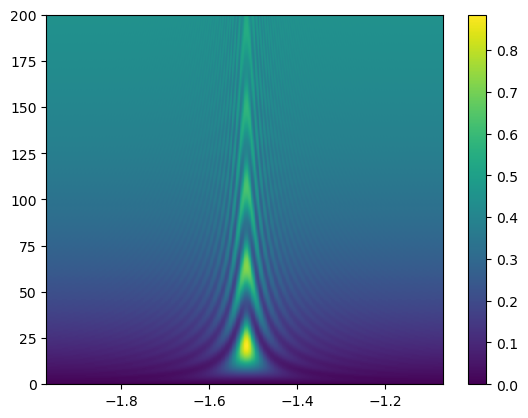

In [436]:
plt.pcolormesh(detuning_scan/2/np.pi, time_array, np.array(out).T)
plt.colorbar()
plt.savefig(filename[:-4]+'.png', dpi=100, bbox_inches='tight', facecolor='white')

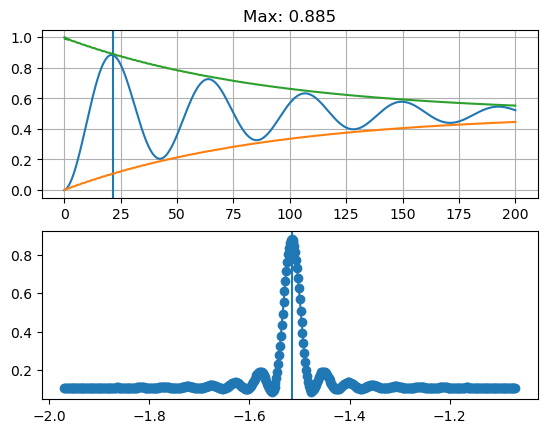

In [462]:
j = np.searchsorted(detuning_scan, shift) + 2
central = detuning_scan[j] 
f = plt.figure()
ax = f.add_subplot(211)
ax.axvline(x=pi_pulse)
ax.grid()
ax.plot(time_array, out[j])
# ax.plot(time_array, out1[j])
ax.plot(time_array, out[-1])
ax.plot(time_array, out1[-1])
# ax.set_ylim(0, 1)
ax.set_title('Max: %.3f'%max(out[j]))
# ax.plot(time_array, 0.5 + 0.5*np.exp(-time_array*gamma01))
# ax.plot(time_array, 0.5*(1-np.exp(-time_array*gamma01)))

ax = f.add_subplot(212)
val = np.searchsorted(time_array, pi_pulse)
ax.plot(detuning_scan/2/np.pi, out[:,val],'o-')
ax.axvline(x=central/2/np.pi)

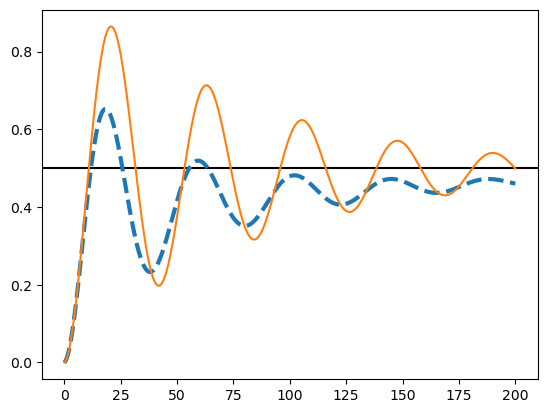

In [466]:
t2star = 13
sigma = np.sqrt(2)/t2star
smooth_out = np.array([out[j]*np.exp(-(detuning_scan[j] - central)**2/2/sigma/sigma) for j in range(len(detuning_scan))]).sum(axis=0)

plt.axhline(y=0.5, color='black')
smooth_out /= np.exp(-(detuning_scan - central)**2/2/sigma/sigma).sum(axis=0)
plt.plot(time_array, smooth_out,'--',lw=3)
# plt.plot(time_array, 0.5*smooth_out/np.mean(smooth_out),'--',lw=3)
opt = np.searchsorted(detuning_scan, shift)
plt.plot(time_array, out[opt])

# Fitting

In [351]:
import pickle
def read_pickle_basic(filename):
    '''
    data = pickle.load(filename)
    Return data['info'], data['data']
    '''
    f = open(filename, "rb")
    data = pickle.load(f)
    return data['info'], data['data']

filename = r'Z:\RawData\2024\08\09\CRYO1\204330_ODMR\20240809-235150_Rabi_0p9RamseyCooling_HWP_54.239deg_QWP_50.349deg_Cooling_0.130V_RamanPower_1.100V_Bias_-0.240V.pickle'
info,data = read_pickle_basic(filename)
int_time = info['int_time']
pl = np.concatenate([data['pulse_length'],data['gap_length']-data['pulse_length'][::-1]])
detuning = 1e3*(data['mw_freq_Ghz'] - data['freq_cooling_GHz'])
timings = np.array(data['rf_pulse'])[:,0]
index = np.where(timings == data['rf_readout'])[0][-3:]
resolution_ns = info['bin_ns']
start_index = 255 + 160#328
roi = [start_index//resolution_ns + (timings[:index[0]]).sum()//resolution_ns]
signal_length = data['rf_readout']*0.95
roi.append(roi[-1]+(signal_length/2)//resolution_ns)
roi.append(roi[-1]+(signal_length/2)//resolution_ns)
roi.append(start_index//resolution_ns + (timings[:index[1]]).sum()//resolution_ns)
roi.append(roi[-1]+(signal_length/2)//resolution_ns)
roi.append(roi[-1]+(signal_length/2)//resolution_ns)
roi.append(start_index//resolution_ns + (timings[:index[2]]).sum()//resolution_ns)
roi.append(roi[-1]+(signal_length/2)//resolution_ns)
roi.append(roi[-1]+(signal_length/2)//resolution_ns)
roi = np.array(roi, dtype='int')

readout_counts = []
for j in range(len(data['counts'])):
    ini = data['counts'][j][roi[0]:roi[1]].sum() - data['counts'][j][roi[1]:roi[2]].sum()  
    read0 = data['counts'][j][roi[3]:roi[4]].sum() - data['counts'][j][roi[4]:roi[5]].sum()  
    read1 = data['counts'][j][roi[6]:roi[7]].sum() - data['counts'][j][roi[7]:roi[8]].sum()  
    readout_counts.append([ini, read0, read1])
readout_counts = np.array(readout_counts)
initialization = readout_counts[:,0].reshape((detuning.shape[0],data['pulse_length'].shape[0]))
readout = readout_counts[:,1].reshape((detuning.shape[0],data['pulse_length'].shape[0]))
readout1 = readout_counts[:,2].reshape((detuning.shape[0],data['pulse_length'].shape[0]))
total_readout = np.concatenate([readout.T, np.fliplr(readout1).T])
total_initialize = np.concatenate([initialization.T, np.fliplr(initialization).T])

def envelope_t1(x, amp, t1_decay):
    # x -= x0
    return amp*0.5*(1-np.exp(-x/t1_decay))

def fit_decay_t1(x,y):
    mod = Model(envelope_t1)
    params = mod.make_params(amp=max(y),t1_decay = 100)
    res = mod.fit(y, params, x=x)
    xfit = np.linspace(min(x)*0, max(x), 1001)
    yfit = mod.eval(res.params,x=xfit)
    return res, mod, xfit, yfit

def rabi_flops(x, amp , gamma, omega):
    omega2 = np.sqrt(4*omega**2 - gamma**2)
    norm =  0.5*(1+np.exp(-x*gamma)*(np.cos(omega2*x/2)))#np.cos(omega*x)))
    # norm =  0.5*(1+np.exp(-1.5*x*gamma)*(np.cos(omega2*x/2)-(gamma/omega2)*np.sin(omega2*x/2)))#np.cos(omega*x)))
    return amp*(1-norm)

def fit_rabi_flops(x, y):
    mod = Model(rabi_flops)
    mod.set_param_hint('decay_t2',expr='gamma**(-1)')
    mod.set_param_hint('rabi_freq_MHz',expr='1e3*omega/2/pi')
    params = mod.make_params(amp=np.mean(y)*2, x0 = -10, gamma=1/20, omega=2*np.pi*0.022)
    res = mod.fit(y, params,x=x)
    xfit = np.linspace(0, max(x), 1001)
    yfit = mod.eval(res.params, x=xfit)
    return res, mod, xfit, yfit

[[Model]]
    Model(envelope_t1)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 101
    # variables        = 2
    chi-square         = 0.11556486
    reduced chi-square = 0.00116732
    Akaike info crit   = -680.077430
    Bayesian info crit = -674.847189
    R-squared          = 0.97102740
[[Variables]]
    amp:       1.67574344 +/- 0.03544189 (2.11%) (init = 0.8117554)
    t1_decay:  91.0944342 +/- 4.07173296 (4.47%) (init = 100)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, t1_decay) = +0.9547


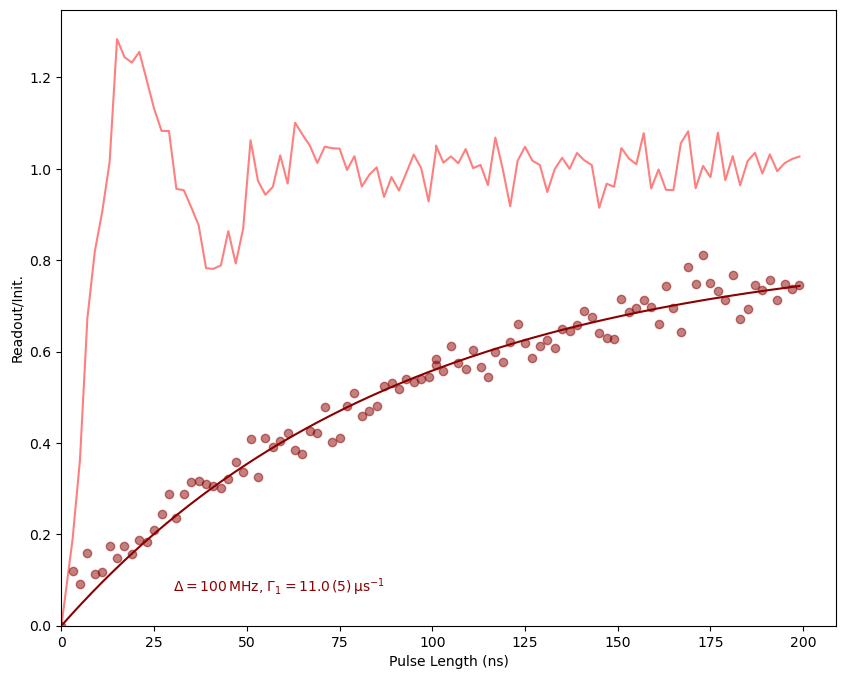

In [352]:
# import sea
from lmfit import Model
def plot_rabi(f, ax):
    color_lst = ['red', 'darkred','orange','darkorange']
    # color_lst = sns.color_palette('rocket', 10)[2:]
    x = detuning
    y = np.concatenate([np.zeros(1),pl-2]) 
    z = total_readout/total_initialize
    prefactor = 1.2/800
    
    idx = np.searchsorted(x,0)  
    ax.plot(y,np.concatenate([np.zeros(1),z[:,idx]]),'-',color=color_lst[0], alpha=0.5)
   
    idx = np.searchsorted(x,90)
    ax.plot(y,np.concatenate([np.zeros(1),z[:,idx]]),'o',color=color_lst[1],alpha=0.5)
    ybg = np.concatenate([np.zeros(1),z[:,idx]])
    res, mod, xfit, yfit = fit_decay_t1(y, np.concatenate([np.zeros(1),z[:,idx]]))
    print (res.fit_report())
    ax.plot(xfit, yfit,color=color_lst[1])
    _xf = xfit
    _yf = yfit
    ax.set_xlabel('Pulse Length (ns)')
    if prefactor==1:
        ax.set_ylabel('Counts/s')
    else:
        ax.set_ylabel('Readout/Init.')
    ax.text(30, 50*prefactor, '$\Delta=100\,$MHz, $\Gamma_1=$%.1f$\,$(%.0f)$\,\mathregular{\mu s}^{-1}$'%(1e3/res.params['t1_decay'].value,
                                                                                     10*(1e3/res.params['t1_decay'].value)*res.params['t1_decay'].stderr/res.params['t1_decay'].value), color=color_lst[1])
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    idx = np.searchsorted(x,0) 
    return y,np.concatenate([np.zeros(1),z[:,idx]]), ybg, _xf, _yf

f = plt.figure(figsize=(10,8))
ax  = f.add_subplot(111)
xdata, ydata, ybg,_xf, _yf = plot_rabi(f, ax)

In [382]:
def t2star_rabi(x, esrdetuning, Omega, t1, t2star, td):
    # t2star = 17
    output_array = np.zeros(len(x))
    
    if t2star !=0:
        width = abs(np.sqrt(2)/t2star)
        detuning_array = np.linspace(-3*width, 3*width, 51) + esrdetuning
        stepsize = np.diff(detuning_array)[0]
        for j, _detuning in enumerate(detuning_array):
            Hamiltonian = -_detuning/2 * qp.sigmaz() + Omega/2 * qp.sigmax()
            psi0 = qp.fock(2, 0)*qp.fock(2,0).dag()
            gamma01 = 1/t1
            dephase = 1/td
            decay01 = np.sqrt(gamma01/2)*qp.sigmax() 
            dephasing = np.sqrt(dephase/2)*qp.sigmaz()
            pop0 = qp.fock(2, 0)*qp.fock(2,0).dag()
            pop1 = qp.fock(2, 1)*qp.fock(2,1).dag()
            res = qp.mesolve(Hamiltonian,
                         psi0,
                         x,
                         e_ops=[pop1], 
                         c_ops=[decay01, dephasing]
                        )
            output_array += res.expect[0]*gaussian(_detuning,0,width)*stepsize
    else:
        Hamiltonian = -esrdetuning/2 * qp.sigmaz() + Omega/2 * qp.sigmax()
        psi0 = qp.fock(2, 0)*qp.fock(2,0).dag()
        gamma01 = 1/t1
        dephase = 1/td
        decay01 = np.sqrt(gamma01/2)*qp.sigmax() 
        dephasing = np.sqrt(dephase/2)*qp.sigmaz()
        pop0 = qp.fock(2, 0)*qp.fock(2,0).dag()
        pop1 = qp.fock(2, 1)*qp.fock(2,1).dag()
        res = qp.mesolve(Hamiltonian,
                     psi0,
                     x,
                     e_ops=[pop1], 
                     c_ops=[decay01, dephasing]
                    )
        output_array += res.expect[0]
    return output_array

In [387]:
from lmfit.model import Model
def per_iteration(pars, iteration, resid, *args, **kws):
    # print ()
    print(" ITER ", iteration, f'Residual: {np.sum(resid**2):.3f}' , [f"{p.name} = {p.value:.5f}" for p in pars.values()])
x = xdata
y = 0.5*ydata

mod = Model(t2star_rabi)
params = mod.make_params(esrdetuning={'vary': False,'value':0.00,'min':-0.1, 'max':0.1}, Omega={'vary':True,'min':0,'value':0.1516},
                         t1={'vary':False,'value':91.0944342}, 
                         t2star={'vary':False,'value':17}, 
                         td={'vary':True,'value':18.73, 'min':0})
result = mod.fit(y, params, x=x, iter_cb=per_iteration)
xfit = np.linspace(min(x), max(x), 501)
yfit = mod.eval(result.params,x=xfit)


 ITER  -1 Residual: 0.067 ['esrdetuning = 0.00000', 'Omega = 0.15160', 't1 = 91.09443', 't2star = 17.00000', 'td = 18.73000']
 ITER  0 Residual: 0.067 ['esrdetuning = 0.00000', 'Omega = 0.15160', 't1 = 91.09443', 't2star = 17.00000', 'td = 18.73000']
 ITER  1 Residual: 0.067 ['esrdetuning = 0.00000', 'Omega = 0.15160', 't1 = 91.09443', 't2star = 17.00000', 'td = 18.73000']
 ITER  2 Residual: 0.067 ['esrdetuning = 0.00000', 'Omega = 0.15160', 't1 = 91.09443', 't2star = 17.00000', 'td = 18.73000']
 ITER  3 Residual: 0.067 ['esrdetuning = 0.00000', 'Omega = 0.15160', 't1 = 91.09443', 't2star = 17.00000', 'td = 18.73020']
 ITER  4 Residual: 0.067 ['esrdetuning = 0.00000', 'Omega = 0.15082', 't1 = 91.09443', 't2star = 17.00000', 'td = 18.58580']
 ITER  5 Residual: 0.067 ['esrdetuning = 0.00000', 'Omega = 0.15082', 't1 = 91.09443', 't2star = 17.00000', 'td = 18.58580']
 ITER  6 Residual: 0.067 ['esrdetuning = 0.00000', 'Omega = 0.15082', 't1 = 91.09443', 't2star = 17.00000', 'td = 18.58599']

[[Model]]
    Model(t2star_rabi)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 101
    # variables        = 2
    chi-square         = 0.06707056
    reduced chi-square = 6.7748e-04
    Akaike info crit   = -735.030193
    Bayesian info crit = -729.799952
    R-squared          = 0.90612059
[[Variables]]
    esrdetuning:  0 (fixed)
    Omega:        0.15070923 +/- 0.00247101 (1.64%) (init = 0.1516)
    t1:           91.09443 (fixed)
    t2star:       17 (fixed)
    td:           18.7485169 +/- 1.62001918 (8.64%) (init = 18.73)
[[Correlations]] (unreported correlations are < 0.100)
    C(Omega, td) = -0.5755


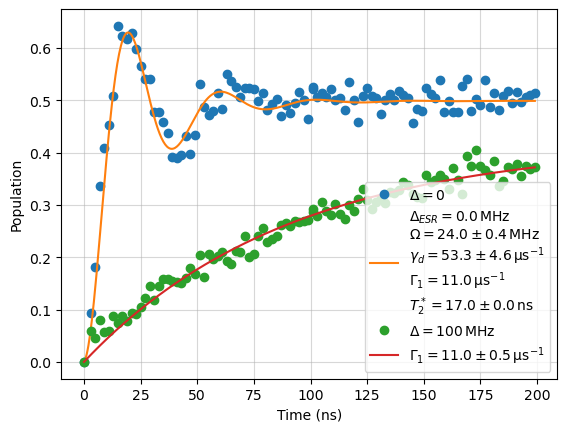

In [388]:
f = plt.figure()
ax = f.add_subplot(111)
ax.plot(xdata, 0.5*ydata,'o',label='$\Delta=0$')
ax.plot(xfit, yfit, label='$\Delta_{ESR}=%.1f\,$MHz\n$\Omega=%.1f\pm %.1f\,$MHz\n$\gamma_d=%.1f\pm%.1f\,\mathregular{\mu s}^{-1}$\n$\Gamma_1=%.1f\,\mathregular{\mu s}^{-1}$\n$T_2^*=%.1f\pm %.1f\,$ns'%(
                                                                                                        result.params['esrdetuning'].value,1e3*result.params['Omega'].value/2/np.pi,
                                                                                                        1e3*result.params['Omega'].stderr/2/np.pi,
                                                                                                       1e3/result.params['td'].value,
                                                                                                       1e3/result.params['td'].value*(result.params['td'].stderr/result.params['td'].value),
                                                                                                                                                  11, result.params['t2star'].value, result.params['t2star'].stderr))
ax.plot(xdata, 0.5*ybg,'o',label='$\Delta=100\,$MHz')
ax.plot(_xf, 0.5*_yf, label='$\Gamma_1=%.1f\pm %.1f\,\mathregular{\mu s}^{-1}$'%(11,0.5))
ax.legend()
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Population')
# plt.axhline(y=0.5, ls='--')
# yguess = mod.eval(params,x=xfit)
# plt.plot(xfit, yguess,'--')
ax.grid(True, alpha=0.5)

print (result.fit_report())
np.savez(filename[:-7]+'_fit2free1.npz', xfit=xfit, yfit=yfit, result=result.params, xbgfit=_xf, ybgfit = _yf, xdata=xdata, ydata=0.5*ydata, ybg=0.5*ybg)
f.savefig(filename[:-7]+'_fit2free1.png', dpi=100, bbox_inches='tight', facecolor='white')

In [391]:
filename[:-7]+'_data.h5'

'Z:\\RawData\\2024\\08\\09\\CRYO1\\204330_ODMR\\20240809-235150_Rabi_0p9RamseyCooling_HWP_54.239deg_QWP_50.349deg_Cooling_0.130V_RamanPower_1.100V_Bias_-0.240V_data.h5'

In [389]:
import h5py

In [401]:
data = np.array([[1, 2], [3, 4]])

# Write the array to an HDF5 file
with h5py.File(filename[:-7]+'_data.h5', 'w') as hf:
    hf.create_dataset('time_ns', data=xdata)
    hf.create_dataset('population', data=0.5*ydata)
    hf.create_dataset('population_off_resonance', data=0.5*ybg)

In [403]:
with h5py.File(filename[:-7]+'_data.h5', 'r') as hf:
        loaded_data = hf['time_ns'][:]
        loaded_data = hf['population'][:]
        loaded_data = hf['population_off_resonance'][:]
        print(loaded_data)

[0.         0.05989049 0.04526607 0.0801063  0.05624543 0.05837563
 0.08697234 0.07385524 0.08697234 0.07892857 0.09341998 0.09142212
 0.10440395 0.12255257 0.14455917 0.11803406 0.14445331 0.1577424
 0.15855404 0.15537849 0.1533052  0.15033911 0.16074074 0.17926647
 0.16828721 0.20445344 0.16250866 0.20567121 0.19604182 0.20211961
 0.21047009 0.19233746 0.18754804 0.2127572  0.21072319 0.23985959
 0.2006555  0.20529328 0.23994039 0.25522042 0.22929217 0.23516643
 0.24054855 0.26233184 0.26612277 0.25913242 0.2695369  0.26678967
 0.26977612 0.27170198 0.2856049  0.29211332 0.27853725 0.30559701
 0.28745387 0.28147612 0.3021309  0.28360528 0.27242152 0.29911045
 0.28835022 0.31061747 0.33023975 0.30923994 0.29291845 0.30626366
 0.31318253 0.30340815 0.32510288 0.32244427 0.32933437 0.34401709
 0.33838002 0.32038835 0.31442929 0.31392931 0.35708502 0.34293194
 0.34805389 0.35666667 0.34890731 0.32981716 0.37131474 0.34717251
 0.32091172 0.39305666 0.37383901 0.40587768 0.37527194 0.36636